# LAB 7

    
> https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29#

## Preparation (30 points total)

### Preparation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
drug_reviews_test = pd.read_table("drugsComTest_raw.tsv")
drug_reviews_train = pd.read_table("drugsComTrain_raw.tsv")
drug_reviews_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


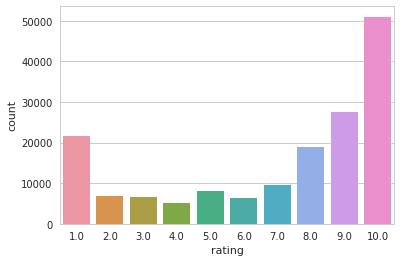

In [2]:
drug_reviews_train = drug_reviews_train[["review", "rating"]]
drug_reviews_test = drug_reviews_test[["review", "rating"]]
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x="rating", data=drug_reviews_train)
plt.show()

In [3]:
print("Size:", drug_reviews_train.size)
drug_reviews_train['length'] = drug_reviews_train['review'].apply(len)
drug_reviews_train.head()


Size: 322594


,review,rating,length
0,"""It has no side effect, I take it in combinati...",9.0,79
1,"""My son is halfway through his fourth week of ...",8.0,741
2,"""I used to take another oral contraceptive, wh...",5.0,755
3,"""This is my first time using any form of birth...",8.0,448
4,"""Suboxone has completely turned my life around...",9.0,719


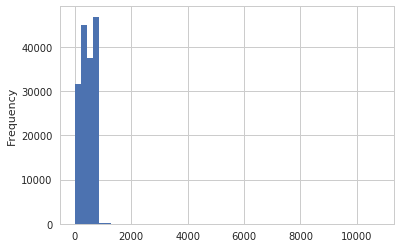

In [4]:
drug_reviews_train['length'].plot(bins=50,kind = 'hist')

In [5]:
import numpy as np
X_test = drug_reviews_test.drop(columns=["rating"])
y_test = drug_reviews_test["rating"]
X_train = drug_reviews_train.drop(columns=["rating"])
y_train = drug_reviews_train["rating"]

n_samples, n_features = X_train.shape
n_classes = len(np.unique(y_train))

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print(np.unique(y_train))

n_samples: 161297
n_features: 2
n_classes: 10
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


#### Dataset Description

This dataset will have a review for a medicine as text and a rating  as number (0-10).
The goal is to be able to classify the review as having a certain rating.

### Tokenization

In [6]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = 5000
MAX_LEN = 200 # maximum and minimum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X_train["review"].values)
sequences = tokenizer.texts_to_sequences(X_train["review"].values)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_LEN)

y_ohe = keras.utils.to_categorical(y_train)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

/home/aviraj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 51429 unique tokens. Distilled to 5000 top words.
Shape of data tensor: (161297, 200)
Shape of label tensor: (161297, 11)
4999


#### Tokenization Description
We made the standard length of 200 because the average review length was 100 and 100+- 100 covered most of the values.
The tokenization method was to import data from tsv into data frame then put the numpy corpus of reviews through the keras `texts_to_sequences`.

In [7]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=y_train, 
                                                            random_state=42)
NUM_CLASSES = 11
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(129037, 200) (129037, 11)
[    0. 17295.  5545.  5210.  4010.  6410.  5074.  7565. 15112. 22025.
 40791.]


### Performance Metrics    

The value of the model developed is that it would allow a system to be able to mass read the reviews of all drugs. The through the rating system it could choose drugs that are the most effective and therefore most profitable. This benefits people as well, by allowing patient feedback to become the most important factor in choosing which drugs are available for purchase.

Precision is important because the algorithm is more used for weeding out drugs that do not work and choosing only the best to market rather than recalling that most of the drugs that are working.

Precision of 80% is not bad since this means that 80% of the ratings classified correctly out of the 10. MSE would give us more specifics on the range of difference but precision would be enough to compare fairly.

### Cross validation method    

Since the model will be used by various pharmacies the amount of drug types in each would not be the same anyway. Therefore, kfold shuffled and without stratification would give the most realistic mirroring. 5 folds should be enough for our dataset size and diversity.

## Modeling (60 points total)

### LSTM and GRU
[20 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Be sure to use an embedding layer (pre-trained, from scratch, or both). Adjust hyper-parameters of the networks as needed to improve generalization performance. 
#### add precision score

In [8]:
#from github https://github.com/GeekLiB/keras/blob/master/keras/metrics.py
import functools
from keras import backend as K
from sklearn.metrics import precision_score

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#### Compile code

In [9]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding


EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=200)(input_holder) # number of words in each sequence

for func in [SimpleRNN, LSTM, GRU]:
    
    x = func(50, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    rnn=Model(inputs=input_holder,outputs=x)
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[precision])
    print(rnn.summary())
    rnns.append(rnn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 50)           250000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 11)                561       
Total params: 255,611
Trainable params: 255,611
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________

## Subsampling if needed

In [10]:
X_train = X_train[:1000]
y_train_ohe = y_train_ohe[:1000]
X_test = X_test[:200]
y_test_ohe = y_test_ohe[:200]

### Dry run( may remove)

In [11]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('Round 2 training,',name,'========')
    rnn.fit(X_train, y_train_ohe, epochs=3, batch_size=64, validation_data=(X_test, y_test_ohe))

Round 2 training, simple ========
Train on 1000 samples, validate on 200 samples
Epoch 1/3
1000/1000 [==============================] - 1s 1ms/step - loss: 0.7005 - precision: 0.0859 - val_loss: 0.6068 - val_precision: 0.1002
Epoch 2/3
1000/1000 [==============================] - 1s 998us/step - loss: 0.6356 - precision: 0.0973 - val_loss: 0.4947 - val_precision: 0.0000e+00
Epoch 3/3
1000/1000 [==============================] - 1s 998us/step - loss: 0.5486 - precision: 0.0988 - val_loss: 0.4091 - val_precision: 0.0000e+00
Round 2 training, lstm ========
Train on 1000 samples, validate on 200 samples
Epoch 1/3
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4630 - precision: 0.0320 - val_loss: 0.2981 - val_precision: 0.0000e+00
Epoch 2/3
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2827 - precision: 0.0000e+00 - val_loss: 0.2775 - val_precision: 0.0000e+00
Epoch 3/3
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2717 - precisi

## LSTM and GRU crossvalidation comparison and visualizaion

In [12]:
from sklearn.model_selection import KFold

def cross_validate(func):
    # Instantiate the cross validator
    kf = KFold(n_splits=5, shuffle=True)

    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(kf.split(X_train, y_train_ohe)):
        print("Training on fold " + str(index+1) + "/5...")

        # Generate batches from indices
        xtrain, xval = X_train[train_indices], X_train[val_indices]
        ytrain, yval = y_train_ohe[train_indices], y_train_ohe[val_indices]

        x = func(50, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
        x = Dense(NUM_CLASSES, activation='sigmoid')(x)
        rnn=Model(inputs=input_holder,outputs=x)
        rnn.compile(loss='categorical_crossentropy', 
                      optimizer='rmsprop', 
                      metrics=[precision])
    

        history = rnn.fit(xtrain, ytrain, epochs=30, batch_size=64, validation_data=(xval, yval), verbose=0)
    accuracy_history = history.history['precision']
    val_accuracy_history = history.history['val_precision']
    print("Last training precision: " + str(accuracy_history[-1]) + ", last validation precision: " + str(val_accuracy_history[-1]))

    return history

In [13]:
def plot_loss_acc(history):

    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['precision'])

    plt.ylabel('Precision %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_precision'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Last training precision: 0.7966591453552246, last validation precision: 0.8135757637023926


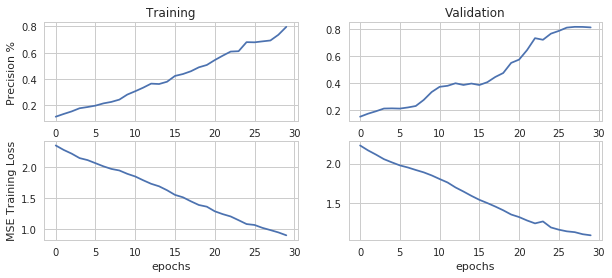

In [14]:
history = cross_validate(SimpleRNN)
plot_loss_acc(history)

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Last training precision: 0.915704562664032, last validation precision: 0.8799066352844238


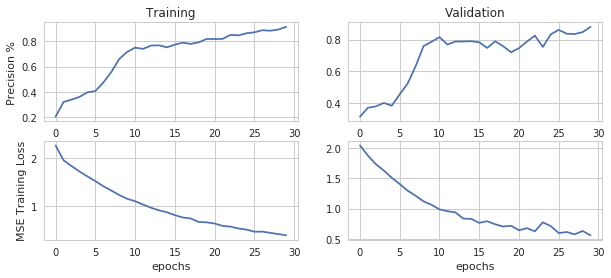

In [15]:
history = cross_validate(LSTM)
plot_loss_acc(history)

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Last training precision: 0.8672605991363526, last validation precision: 0.6809350728988648


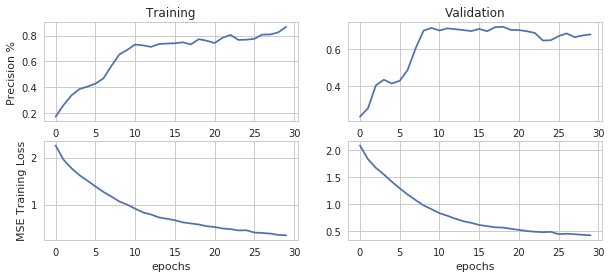

In [16]:
history = cross_validate(GRU)
plot_loss_acc(history)